# Data loading and exploration

In [ ]:
import optuna
import torch
import os
import re
import scipy.io as sio
from glob import glob
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import numpy as np
from torch.utils.data import Dataset, DataLoader

def load_one(file_path, V_rms):
    if not os.path.exists(file_path):
        raise FileNotFoundError(file_path)

    # --- extract metadata from filename ---
    fname = os.path.basename(file_path)
    # Example: sweep_50_500K_9000_1v_t10920_25.8.mat
    m = re.match(r"sweep_(\d+)_([\d\.]+)K_\d+_([\d\.]+)v_t(\d+)_([\d\.]+)\.mat", fname)
    if not m:
        raise ValueError(f"Unexpected filename format: {fname}")
    start_freq = float(m.group(1))
    stop_freq = float(m.group(2)) * 1e3  # convert K→Hz
    stim_voltage = float(m.group(3))
    weight = float(m.group(4)) / 100      # 10920 → 109.20 g
    temperature = float(m.group(5))


    # --- load .mat ---
    S = sio.loadmat(file_path, squeeze_me=True, struct_as_record=False)
    fn = [k for k in S.keys() if not k.startswith("__")]
    dev = getattr(S[fn[0]], "demods", None)
    if dev is None or not hasattr(dev, "sample"):
        raise KeyError(f"No dev.demods.sample in {file_path}")

    s = dev.sample
    if isinstance(s, (list, np.ndarray)) and len(s) > 0:
        s = s[0]

    f = np.array(s.frequency, dtype=float)
    X = np.array(s.x, dtype=float)
    Y = np.array(s.y, dtype=float)

    # Complex current and impedance
    I = X + 1j * Y
    I_mag = np.abs(I)
    epsI = max(np.max(I_mag) * 1e-12, 1e-18)
    I[I_mag < epsI] = epsI

    Z = V_rms / I
    R = np.real(Z)
    Xc = np.imag(Z)
    Zmag = np.abs(Z)
    Zphase = np.degrees(np.angle(Z))

    return {
        "file": file_path,
        "f": f,
        "R": R,
        "Xc": Xc,
        "Zmag": Zmag,
        "Zphase": Zphase,
        "weight_g": weight,
        "temperature_C": temperature,
        "V_rms": V_rms,
        "start_freq": start_freq,
        "stop_freq": stop_freq,
        "stim_voltage": stim_voltage,
    }

# Example usage
data_dir = r"Datafolder"
files = glob(os.path.join(data_dir, "*.mat"))

datasets = [
    load_one(f, V_rms=1.0)
    for f in files
]


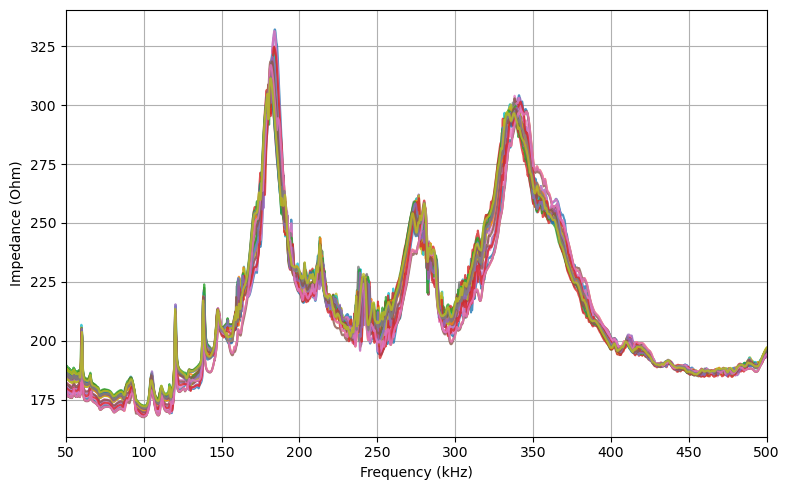

In [3]:
plt.figure(figsize=(8, 5))
for d in datasets:
    label = f"{d['temperature_C']}°C, {d['weight_g']:.2f}g"
    plt.plot(d["f"] / 1000, d["R"], label=f"R - {label}", alpha=0.8)
    #plt.plot(d["f"] / 1000, d["Xc"], linestyle="--", label=f"Xc - {label}", alpha=0.8)

plt.xlim(50, 500)
#plt.xlim(150, 200)
plt.xlabel("Frequency (kHz)")
plt.ylabel("Impedance (Ohm)")
#plt.legend(fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

# ML Pipeline

## 0. Config

In [ ]:
# Frequency range parameters (in kHz) for feature extraction
freq_start_khz = 50   # Change this to set start frequency
freq_stop_khz = 500    # Change this to set stop frequency

# Study configuration
study_name = f"impedance_optimization_{freq_start_khz}_{freq_stop_khz}kHz"
storage_url = "sqlite:///optuna_study.db"

TUNA_TRAILS = 300
NUM_OF_EPOCHS = 300

# Load existing study
study = optuna.create_study(
    study_name=study_name,
    storage=storage_url,
    direction="minimize",
    load_if_exists=True
)

[I 2025-10-21 15:03:59,297] Using an existing study with name 'impedance_optimization' instead of creating a new one.


## 1. Data prep

In [ ]:
# Build dataset matrix
freqs = datasets[0]["f"]
X_data, y_data = [], []

for d in datasets:
    # Filter data by frequency range
    freq_khz = d["f"] / 1000
    freq_mask = (freq_khz >= freq_start_khz) & (freq_khz <= freq_stop_khz)
    
    R = d["R"][freq_mask]
    Xc = d["Xc"][freq_mask]
    temp = d["temperature_C"]
    # feature vector: concatenate R, Xc, and temp
    #features = np.concatenate([R, Xc, [temp]])
    features = np.concatenate([R])
    X_data.append(features)
    y_data.append(d["weight_g"] - 115.0)  # target: delta weight

X_data = np.array(X_data, dtype=np.float32)
y_data = np.array(y_data, dtype=np.float32).reshape(-1, 1)

# Normalize features (zero mean, unit variance)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_data = scaler.fit_transform(X_data)

## 2. Pytorch dataset

In [34]:
class ImpedanceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = ImpedanceDataset(X_data, y_data)


## 3. Train/Validate split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.3, random_state=42)
train_ds = ImpedanceDataset(X_train, y_train)
val_ds = ImpedanceDataset(X_val, y_val)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)


## 4. Define model

In [36]:
class ImpedanceNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_channels, kernel_size, stride, dropout):
        super().__init__()
        self.input_dim = input_dim
        
        # Calculate dimensions after conv layers
        def conv_output_size(input_size, kernel_size, stride, padding):
            return (input_size + 2 * padding - kernel_size) // stride + 1
        
        # First conv layer
        padding1 = kernel_size // 2
        size_after_conv1 = conv_output_size(input_dim, kernel_size, stride, padding1)
        
        # Second conv layer  
        size_after_conv2 = conv_output_size(size_after_conv1, kernel_size, stride, padding1)
        
        # Third conv layer
        size_after_conv3 = conv_output_size(size_after_conv2, kernel_size, stride, padding1)
        
        self.conv_layers = torch.nn.Sequential(
            torch.nn.Conv1d(1, hidden_channels, kernel_size, stride=stride, padding=padding1),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Conv1d(hidden_channels, hidden_channels*2, kernel_size, stride=stride, padding=padding1),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Conv1d(hidden_channels*2, hidden_channels*4, kernel_size, stride=stride, padding=padding1),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout)
        )
        
        # Calculate final feature size
        final_features = hidden_channels * 4 * size_after_conv3
        self.fc = torch.nn.Linear(final_features, 1)
        
    def forward(self, x):
        # x shape: (batch, features) -> (batch, 1, features)
        x = x.unsqueeze(1)
        x = self.conv_layers(x)
        x = x.flatten(1)
        return self.fc(x)

## 5. Optuna hyperparam search

In [18]:
# Check CUDA availability and GPU information
print("CUDA Setup Information:")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("CUDA not available - will use CPU for training")
print()

CUDA Setup Information:
CUDA Available: True
CUDA Version: 11.8
Number of GPUs: 1
Current GPU: NVIDIA GeForce RTX 4090
GPU Memory: 25.8 GB



In [ ]:
def objective(trial):
    # Check if CUDA is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Hyperparameters to optimize
    hidden_channels = trial.suggest_int("hidden_channels", 8, 64)
    kernel_size = trial.suggest_int("kernel_size", 3, 40, step=2)  # Expanded range
    stride = trial.suggest_int("stride", 1, 40)  # New parameter
    dropout = trial.suggest_float("dropout", 0.0, 1)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    epochs = NUM_OF_EPOCHS

    try:
        model = ImpedanceNet(X_train.shape[1], hidden_channels, kernel_size, stride, dropout)
        model = model.to(device)  # Move model to GPU if available
        
        opt = torch.optim.Adam(model.parameters(), lr=lr)
        loss_fn = torch.nn.MSELoss()

        for epoch in range(epochs):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)  # Move data to GPU
                pred = model(xb)
                loss = loss_fn(pred, yb)
                opt.zero_grad()
                loss.backward()
                opt.step()

        # Validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)  # Move data to GPU
                pred = model(xb)
                val_loss += loss_fn(pred, yb).item()
        
        return val_loss / len(val_loader)
        
    except RuntimeError as e:
        if "out of memory" in str(e):
            # If GPU runs out of memory, return a high loss to penalize this configuration
            print(f"GPU out of memory for trial {trial.number}: {e}")
            return float('inf')
        else:
            raise e

study = optuna.create_study(
    study_name=study_name,
    storage=storage_url,
    direction="minimize",
    load_if_exists=True  # Load existing study if it exists
)

print(f"Study created/loaded: {study_name}")
print(f"Database URL: {storage_url}")
print(f"Number of completed trials: {len(study.trials)}")

study.optimize(objective, n_trials=TUNA_TRAILS)  # Increased trials for better exploration

print(f"\nBest parameters: {study.best_params}")
print(f"Best validation loss: {study.best_value:.4f}")
print(f"\nTo view results in dashboard, run:")
print(f"optuna-dashboard {storage_url}")

[I 2025-10-21 12:13:39,045] A new study created in memory with name: no-name-cb50e6c6-edce-4441-a7b8-639158b54e4d
[I 2025-10-21 12:15:32,164] Trial 0 finished with value: 4654.68212890625 and parameters: {'hidden_channels': 20, 'kernel_size': 3, 'dropout': 0.42413611255248174, 'lr': 0.0005204249228946794}. Best is trial 0 with value: 4654.68212890625.
[I 2025-10-21 12:15:32,164] Trial 0 finished with value: 4654.68212890625 and parameters: {'hidden_channels': 20, 'kernel_size': 3, 'dropout': 0.42413611255248174, 'lr': 0.0005204249228946794}. Best is trial 0 with value: 4654.68212890625.
[I 2025-10-21 12:17:25,571] Trial 1 finished with value: 2.606856346130371 and parameters: {'hidden_channels': 18, 'kernel_size': 9, 'dropout': 0.4118014358422435, 'lr': 0.006937730458326272}. Best is trial 1 with value: 2.606856346130371.
[I 2025-10-21 12:17:25,571] Trial 1 finished with value: 2.606856346130371 and parameters: {'hidden_channels': 18, 'kernel_size': 9, 'dropout': 0.4118014358422435, 'l

## 6. Train final model with best parameters

In [37]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device: {device}")

best_params = study.best_params
print(f"Best parameters: {best_params}")

model = ImpedanceNet(
    X_train.shape[1], 
    best_params["hidden_channels"], 
    best_params["kernel_size"], 
    best_params["stride"],  # New parameter
    best_params["dropout"]
)
model = model.to(device)  # Move model to GPU

opt = torch.optim.Adam(model.parameters(), lr=best_params["lr"])
loss_fn = torch.nn.MSELoss()

# Training loop with progress tracking
train_losses = []
for epoch in range(200):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)  # Move data to GPU
        opt.zero_grad()
        loss = loss_fn(model(xb), yb)
        loss.backward()
        opt.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/200, Average Loss: {avg_loss:.4f}")

print("Training completed!")

Training on device: cuda
Best parameters: {'hidden_channels': 58, 'kernel_size': 13, 'stride': 2, 'dropout': 0.005510332358429864, 'lr': 0.002859343557286066}
Epoch 50/200, Average Loss: 20.2615
Epoch 50/200, Average Loss: 20.2615
Epoch 100/200, Average Loss: 19.6588
Epoch 100/200, Average Loss: 19.6588
Epoch 150/200, Average Loss: 16.7767
Epoch 150/200, Average Loss: 16.7767
Epoch 200/200, Average Loss: 31.6181
Training completed!
Epoch 200/200, Average Loss: 31.6181
Training completed!


## 7. Evaluate

In [38]:
model.eval()
with torch.no_grad():
    # Move validation data to the same device as model
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
    
    preds = model(X_val_tensor)
    mse = ((preds - y_val_tensor)**2).mean().item()
print(f"Validation MSE: {mse:.4f}")

# Also calculate and display other metrics
mae = torch.abs(preds - y_val_tensor).mean().item()
print(f"Validation MAE: {mae:.4f}")

# Calculate R² score
ss_res = ((preds - y_val_tensor) ** 2).sum()
ss_tot = ((y_val_tensor - y_val_tensor.mean()) ** 2).sum()
r2 = 1 - (ss_res / ss_tot)
print(f"Validation R²: {r2.item():.4f}")

Validation MSE: 17.8912
Validation MAE: 3.8987
Validation R²: -4.6384


## 8. Plot predictions

In [ ]:
model.eval()
with torch.no_grad():
    # Move data to device and get predictions
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_pred = model(X_val_tensor).squeeze().cpu().numpy()  # Move back to CPU for plotting
    y_true = y_val.squeeze()

# Create subplot for better visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Predictions vs True values
ax1.scatter(y_true, y_pred, c="blue", alpha=0.7, edgecolors="k")
ax1.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--", label="Ideal")
ax1.set_xlabel("True weight (g)")
ax1.set_ylabel("Predicted weight (g)")
ax1.set_title("Predicted vs. True Weights")
ax1.legend()
ax1.grid(True)

# Plot 2: Training loss over epochs (if available)
if 'train_losses' in locals():
    ax2.plot(train_losses)
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Training Loss")
    ax2.set_title("Training Loss Over Time")
    ax2.grid(True)
else:
    ax2.text(0.5, 0.5, "Training loss not available", 
             ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title("Training Loss")



plt.tight_layout()
plt.savefig("model_prediction_{freq_start_khz}_{freq_stop_khz}kHz.png")
plt.show()

# Print final model summary
print(f"\nFinal Model Summary:")
print(f"- Hidden channels: {best_params['hidden_channels']}")
print(f"- Kernel size: {best_params['kernel_size']}")
print(f"- Stride: {best_params['stride']}")
print(f"- Dropout: {best_params['dropout']:.3f}")
print(f"- Learning rate: {best_params['lr']:.6f}")
print(f"- Device used: {device}")


Final Model Summary:
- Hidden channels: 58
- Kernel size: 13
- Stride: 2
- Dropout: 0.006
- Learning rate: 0.002859
- Device used: cuda


/tmp/ipykernel_67610/3606652271.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
